In [1]:
%load_ext autoreload
%autoreload 2

In [230]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from joblib import dump, load
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from utils import preprocessing, eval_clf, eval_clf_perf, eval_clf_roc
import xgboost as xgb

In [3]:
data = pd.read_csv('./data/insurance/train.csv')

In [252]:
processed = data.copy()

#Drop and transform certain columns
processed.drop('id', axis=1, inplace=True)
processed['Policy_Sales_Channel'] = processed['Policy_Sales_Channel'].astype('int32')#.astype('category')
#processed['Region_Code'] = processed['Region_Code'].astype('int32')#.astype('category')
#processed.drop('Policy_Sales_Channel', axis=1, inplace=True)
processed.drop('Region_Code', axis=1, inplace=True)
processed = processed[[c for c in processed if c not in ['Response']]+ ['Response']]

In [253]:
processed.columns

Index(['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
       'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
       'Response'],
      dtype='object')

In [ ]:
region_codes = data['Region_Code'].unique()
positive_ratio = []
for region in region_codes:
    positive_ratio.append(data[(data['Region_Code']==region) & (data['Response']==1)].shape[0]/data[data['Region_Code']==region].shape[0])
print(np.sort(positive_ratio))

In [ ]:
sales_channels = data['Policy_Sales_Channel'].unique()
positive_ratio = []
for region in sales_channels:
    positive_ratio.append(data[(data['Policy_Sales_Channel']==region) & (data['Response']==1)].shape[0]/data[data['Policy_Sales_Channel']==region].shape[0])
print(np.sort(positive_ratio))

In [72]:
processed[['Age','Annual_Premium','Vintage']] = StandardScaler().fit_transform(processed[['Age','Annual_Premium','Vintage']])

In [151]:
## The classes are highly unbalanced towards the 0-class, i.e. most customers are not interested in vehicle insurance
print('#class1/#allsamples: ', data[data['Response']==1].shape[0]/data.shape[0])
print('#class1/#class0: ', data[data['Response']==1].shape[0]/data[data['Response']==0].shape[0])

#class1/#allsamples:  0.12256336113815208
#class1/#class0:  0.13968343206767964


<h2>Test different models</h2>

In [334]:
X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=None)

In [333]:
X_train.columns

Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Gender_Male',
       'Vehicle_Age_smallerthan_1 Year', 'Vehicle_Age_> 2 Years',
       'Vehicle_Damage_Yes'],
      dtype='object')

In [ ]:
## The classes are highly unbalanced towards the 0-class, i.e. most customers are not interested in vehicle insurance
# The imbalance is rouhgly preserved by the sampling
print('#class 1 in testing/#samples in testing: ', y_test[y_test==1].shape[0]/y_test.shape[0])

accuracy: 0.7820139417316085
sensitivity: 0.7571792332720328
precision: 0.33250504736760367
fscore: 0.4620896553212613
specificity: 0.7855182394331054
negative_precision: 0.9582044851347732


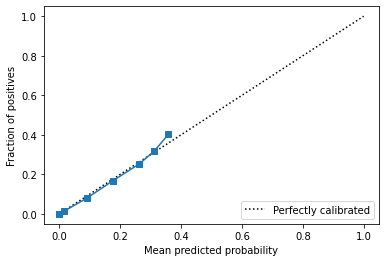

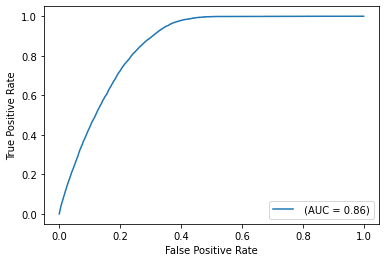

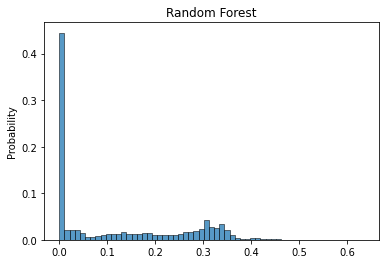

In [332]:
rf_best = RandomForestClassifier(n_jobs=-1, n_estimators=800, max_depth=12, max_features='sqrt', random_state=5).fit(X_train, y_train)
metrics_best = eval_clf(rf_best, X_test, y_test, clf_name='Random Forest', threshold=0.24)

accuracy: 0.7865620599476967
sensitivity: 0.6556089970292828
precision: 0.3218067562406694
fscore: 0.4317086234600964
specificity: 0.8050401716652528
negative_precision: 0.9430726061031217


/opt/homebrew/Caskroom/miniconda/base/envs/ba-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


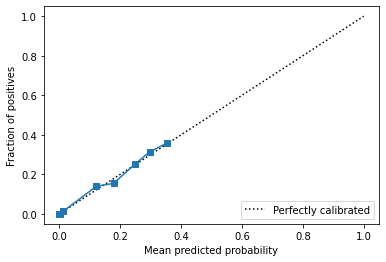

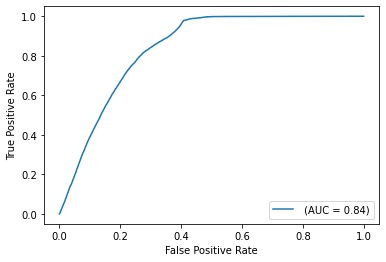

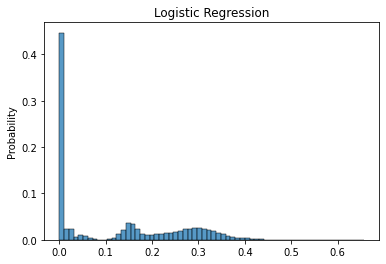

In [279]:
#logistic regression seems to perform worse with upsampling, at least with completely balanced classes
#maybe a smaller upsampling ratio would be more fitting but it probably won't reach the performance of the tree based models
lr = LogisticRegression().fit(X_train, y_train)
metrics_lr = eval_clf(lr, X_test, y_test, clf_name='Logistic Regression', threshold=0.23)

accuracy: 0.7899031775602844
sensitivity: 0.7370915263827982
precision: 0.3391700569568755
fscore: 0.464569912845775
specificity: 0.7973551574429861
negative_precision: 0.9555425318151373


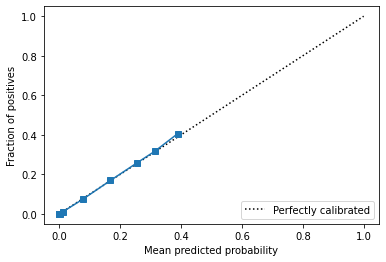

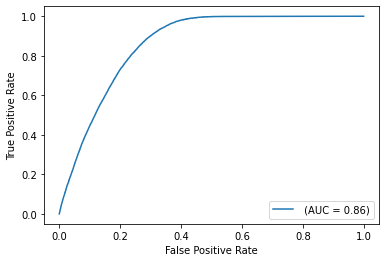

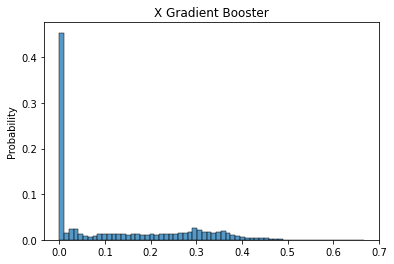

In [337]:
xgbclf = xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bynode=0.6).fit(X_train,y_train)
metrics_xgbclf = eval_clf(xgbclf, X_test, y_test, clf_name='X Gradient Booster', threshold=0.24)

accuracy: 0.7910139679707521
sensitivity: 0.733272032819352
precision: 0.340013119055428
fscore: 0.4645962176212243
specificity: 0.7991616348121163
negative_precision: 0.9550230788497549


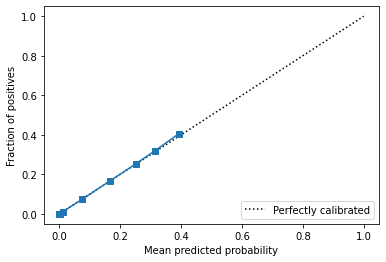

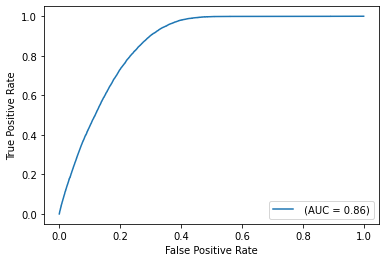

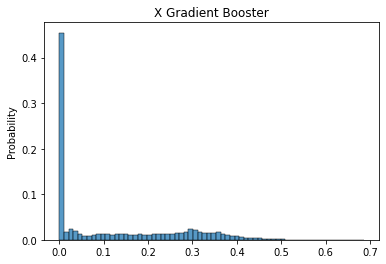

In [343]:
xgbclf = xgb.XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.07, subsample=0.9, colsample_bynode=0.6).fit(X_train,y_train)
metrics_xgbclf = eval_clf(xgbclf, X_test, y_test, clf_name='X Gradient Booster', threshold=0.24)

accuracy: 0.7628681133181147
sensitivity: 0.7841278823030131
precision: 0.3154270756273829
fscore: 0.4498823147471796
specificity: 0.7598682568990469
negative_precision: 0.9614583201788173


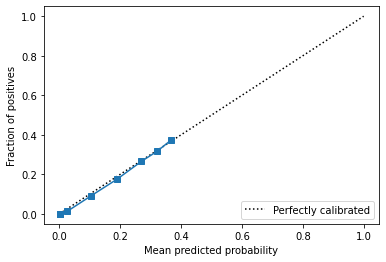

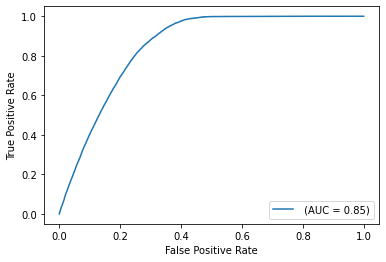

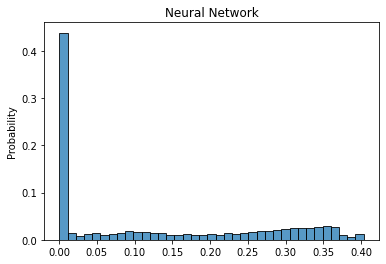

In [286]:
nn = MLPClassifier(hidden_layer_sizes=(150,), alpha=0.07, beta_2=0.97, random_state=42).fit(X_train,y_train)
metrics_nn = eval_clf(nn, X_test, y_test, clf_name='Neural Network', threshold=0.23)

<h2>Use GridSearch to fing the best model</h2>

- Since we have a quite large data set, we omit cross validation and only use a train test split together with gridsearch to find the best model

In [313]:
params_grid = {
    'max_features': ['sqrt', 'log2'],
    'max_depth': [12],
    'random_state': [23]
}
grid = ParameterGrid(params_grid)
X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=None)
grid = ParameterGrid(params_grid)
rf_auc_scores = []
rf_params_list = []
rf_models_list = []
for params in grid:
    rf_model = RandomForestClassifier(**params, n_jobs=-1).fit(X_train,y_train)
    fpr, tpr, _ = roc_curve(y_test.values, rf_model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    rf_auc_scores.append(roc_auc)
    rf_models_list.append(rf_model)
    rf_params_list.append(params)
print(rf_auc_scores)
print(rf_params_list)
print('best auc score: ', max(rf_auc_scores))
print('best params: ', str(rf_params_list[rf_auc_scores.index(max(rf_auc_scores))]))


[0.857433385786103, 0.857433385786103]
[{'max_depth': 12, 'max_features': 'sqrt', 'random_state': 23}, {'max_depth': 12, 'max_features': 'log2', 'random_state': 23}]
best auc score:  0.857433385786103
best params:  {'max_depth': 12, 'max_features': 'sqrt', 'random_state': 23}


In [342]:
params_grid = {
    'learning_rate': [0.07],
    'n_estimators': [200,400,600],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bynode': [0.6],
    'random_state': [23]
}
X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=None)
grid = ParameterGrid(params_grid)
xgb_auc_scores = []
xgb_params_list = []
xgb_models_list = []
for params in grid:
    xgb_model = xgb.XGBClassifier(**params).fit(X_train,y_train)
    fpr, tpr, _ = roc_curve(y_test.values, xgb_model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    xgb_auc_scores.append(roc_auc)
    xgb_models_list.append(xgb_model)
    xgb_params_list.append(params)
print(xgb_auc_scores)
print(xgb_params_list)
print('best auc score: ', max(xgb_auc_scores))
print('best params: ', str(xgb_params_list[xgb_auc_scores.index(max(xgb_auc_scores))]))

[0.8595635539979825, 0.8600420564818676, 0.8596933024032193]
[{'colsample_bynode': 0.6, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 200, 'random_state': 23, 'subsample': 0.9}, {'colsample_bynode': 0.6, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 400, 'random_state': 23, 'subsample': 0.9}, {'colsample_bynode': 0.6, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 600, 'random_state': 23, 'subsample': 0.9}]
best auc score:  0.8600420564818676
best params:  {'colsample_bynode': 0.6, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 400, 'random_state': 23, 'subsample': 0.9}


In [80]:
params_grid = {
    'penalty': ['none', 'l2'],
    'C': [1.0,0.9,0.8],
    'n_jobs': [-1],
}
grid = ParameterGrid(params_grid)
lr_f1_scores = []
lr_params_list = []
for params in grid:
    lr_model = LogisticRegression(**params).fit(X_train,y_train)
    lr_pred = lr_model.predict(X_test)
    lr_f1_scores.append(f1_score(y_test,lr_pred))
    lr_params_list.append(params)
print(lr_f1_scores)
print(lr_params_list)
print('best f1 score: ', max(lr_f1_scores))
print('best params: ', str(lr_params_list[lr_f1_scores.index(max(lr_f1_scores))]))

/opt/homebrew/Caskroom/miniconda/base/envs/ba-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ba-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[0.4015410209263637, 0.4015410209263637, 0.4015410209263637, 0.4015410209263637, 0.4015410209263637, 0.4015410209263637]
[{'C': 1.0, 'n_jobs': -1, 'penalty': 'none'}, {'C': 1.0, 'n_jobs': -1, 'penalty': 'l2'}, {'C': 0.9, 'n_jobs': -1, 'penalty': 'none'}, {'C': 0.9, 'n_jobs': -1, 'penalty': 'l2'}, {'C': 0.8, 'n_jobs': -1, 'penalty': 'none'}, {'C': 0.8, 'n_jobs': -1, 'penalty': 'l2'}]
best f1 score:  0.4015410209263637
best params:  {'C': 1.0, 'n_jobs': -1, 'penalty': 'none'}


In [103]:
params_grid = {
    'hidden_layer_sizes': [(50,),(100,),(150,),(50,50),(100,50),(50,50,50)]
}
grid = ParameterGrid(params_grid)
nn_f1_scores = []
nn_params_list = []
for params in grid:
    nn_model = MLPClassifier(**params).fit(X_train,y_train)
    nn_pred = nn_model.predict(X_test)
    nn_f1_scores.append(f1_score(y_test,nn_pred))
    nn_params_list.append(params)
print(nn_f1_scores)
print(nn_params_list)
print('best f1 score: ', max(nn_f1_scores))
print('best params: ', str(nn_params_list[nn_f1_scores.index(max(nn_f1_scores))]))

[0.4320767603404907, 0.4288672671093287, 0.43470120674688945, 0.42811900034459555, 0.42675977469613624, 0.4231412070363567]
[{'hidden_layer_sizes': (50,)}, {'hidden_layer_sizes': (100,)}, {'hidden_layer_sizes': (150,)}, {'hidden_layer_sizes': (50, 50)}, {'hidden_layer_sizes': (100, 50)}, {'hidden_layer_sizes': (50, 50, 50)}]
best f1 score:  0.43470120674688945
best params:  {'hidden_layer_sizes': (150,)}


In [104]:
params_grid = {
    'hidden_layer_sizes': [(200,),(250,),(300,)]
}
grid = ParameterGrid(params_grid)
nn_f1_scores = []
nn_params_list = []
for params in grid:
    nn_model = MLPClassifier(**params).fit(X_train,y_train)
    nn_pred = nn_model.predict(X_test)
    nn_f1_scores.append(f1_score(y_test,nn_pred))
    nn_params_list.append(params)
print(nn_f1_scores)
print(nn_params_list)
print('best f1 score: ', max(nn_f1_scores))
print('best params: ', str(nn_params_list[nn_f1_scores.index(max(nn_f1_scores))]))

[0.4333467714842438, 0.42833958985623655, 0.4245210235309245]
[{'hidden_layer_sizes': (200,)}, {'hidden_layer_sizes': (250,)}, {'hidden_layer_sizes': (300,)}]
best f1 score:  0.4333467714842438
best params:  {'hidden_layer_sizes': (200,)}


In [105]:
params_grid = {
    'hidden_layer_sizes': [(150,)],
    'alpha': [0.005,0.07],
    'beta_2': [0.97,0.93]
}
grid = ParameterGrid(params_grid)
nn_f1_scores = []
nn_params_list = []
for params in grid:
    nn_model = MLPClassifier(**params).fit(X_train,y_train)
    nn_pred = nn_model.predict(X_test)
    nn_f1_scores.append(f1_score(y_test,nn_pred))
    nn_params_list.append(params)
print(nn_f1_scores)
print(nn_params_list)
print('best f1 score: ', max(nn_f1_scores))
print('best params: ', str(nn_params_list[nn_f1_scores.index(max(nn_f1_scores))]))

[0.42686576875528665, 0.4289113134793666, 0.420740460303188, 0.4241503884395281, 0.4266899371374089, 0.43239908631642127, 0.4223158028053067, 0.43125434732204965]
[{'alpha': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'hidden_layer_sizes': (150,)}, {'alpha': 0.0001, 'beta_1': 0.9, 'beta_2': 0.95, 'hidden_layer_sizes': (150,)}, {'alpha': 0.0001, 'beta_1': 0.7, 'beta_2': 0.999, 'hidden_layer_sizes': (150,)}, {'alpha': 0.0001, 'beta_1': 0.7, 'beta_2': 0.95, 'hidden_layer_sizes': (150,)}, {'alpha': 0.05, 'beta_1': 0.9, 'beta_2': 0.999, 'hidden_layer_sizes': (150,)}, {'alpha': 0.05, 'beta_1': 0.9, 'beta_2': 0.95, 'hidden_layer_sizes': (150,)}, {'alpha': 0.05, 'beta_1': 0.7, 'beta_2': 0.999, 'hidden_layer_sizes': (150,)}, {'alpha': 0.05, 'beta_1': 0.7, 'beta_2': 0.95, 'hidden_layer_sizes': (150,)}]
best f1 score:  0.43239908631642127
best params:  {'alpha': 0.05, 'beta_1': 0.9, 'beta_2': 0.95, 'hidden_layer_sizes': (150,)}


In [106]:
params_grid = {
    'hidden_layer_sizes': [(150,)],
    'alpha': [0.005,0.07],
    'beta_2': [0.97,0.93],
    'random_state':[43]
}
grid = ParameterGrid(params_grid)
nn_f1_scores = []
nn_params_list = []
for params in grid:
    nn_model = MLPClassifier(**params).fit(X_train,y_train)
    nn_pred = nn_model.predict(X_test)
    nn_f1_scores.append(f1_score(y_test,nn_pred))
    nn_params_list.append(params)
print(nn_f1_scores)
print(nn_params_list)
print('best f1 score: ', max(nn_f1_scores))
print('best params: ', str(nn_params_list[nn_f1_scores.index(max(nn_f1_scores))]))

[0.43207572323690174, 0.428562052897552, 0.43474426807760136, 0.43472808310878375]
[{'alpha': 0.005, 'beta_2': 0.97, 'hidden_layer_sizes': (150,), 'random_state': 43}, {'alpha': 0.005, 'beta_2': 0.93, 'hidden_layer_sizes': (150,), 'random_state': 43}, {'alpha': 0.07, 'beta_2': 0.97, 'hidden_layer_sizes': (150,), 'random_state': 43}, {'alpha': 0.07, 'beta_2': 0.93, 'hidden_layer_sizes': (150,), 'random_state': 43}]
best f1 score:  0.43474426807760136
best params:  {'alpha': 0.07, 'beta_2': 0.97, 'hidden_layer_sizes': (150,), 'random_state': 43}


In [328]:
params_grid = {
    'hidden_layer_sizes': [(50,),(100,),(150,),(200,)],
    'alpha': [0.2],
    'beta_2': [0.97],
    'random_state':[42]
}
X_train, X_test, y_train, y_test = preprocessing(data)
grid = ParameterGrid(params_grid)
nn_auc_scores = []
nn_params_list = []
nn_models_list = []
for params in grid:
    nn_model = MLPClassifier(**params).fit(X_train,y_train)
    fpr, tpr, _ = roc_curve(y_test.values, nn_model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    nn_auc_scores.append(roc_auc)
    nn_models_list.append(nn_model)
    nn_params_list.append(params)
print(nn_auc_scores)
print(nn_params_list)
print('best auc score: ', max(nn_auc_scores))
print('best params: ', str(nn_params_list[nn_auc_scores.index(max(nn_auc_scores))]))

[0.8484366621740597, 0.844699912197668, 0.8481606012567474, 0.8476333241705059]
[{'alpha': 0.2, 'beta_2': 0.97, 'hidden_layer_sizes': (50,), 'random_state': 42}, {'alpha': 0.2, 'beta_2': 0.97, 'hidden_layer_sizes': (100,), 'random_state': 42}, {'alpha': 0.2, 'beta_2': 0.97, 'hidden_layer_sizes': (150,), 'random_state': 42}, {'alpha': 0.2, 'beta_2': 0.97, 'hidden_layer_sizes': (200,), 'random_state': 42}]
best auc score:  0.8484366621740597
best params:  {'alpha': 0.2, 'beta_2': 0.97, 'hidden_layer_sizes': (50,), 'random_state': 42}


<h2>Find best sampling strategy</h2>

- Looking at the results below, it seems quite clear that the best class balance seems to be 50-50

In [153]:
downsampling_ratios = [None,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
f1_scores = []
for downsampling_ratio in downsampling_ratios:
    X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=1.0, downsampling_ratio=downsampling_ratio)
    xgbclf = xgb.XGBClassifier(n_estimators=120, max_depth=2, learning_rate=0.2, subsample=0.9, colsample_bynode=0.6).fit(X_train,y_train)
    y_pred = xgbclf.predict(X_test)
    f1_scores.append(f1_score(y_test,y_pred))
print(f1_scores)
print('best f1 score: ', max(f1_scores))

[0.4330962059620596, 0.43338179113560293, 0.43430180294781123, 0.4316396192880753, 0.4311699529892523, 0.43153485588909946, 0.43051483909219673, 0.4259301087412474, 0.42770506462889196]
best f1 score:  0.43430180294781123


In [154]:
downsampling_ratios = [None,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
f1_scores = []
for downsampling_ratio in downsampling_ratios:
    X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=1.0, downsampling_ratio=downsampling_ratio)
    model = RandomForestClassifier(n_jobs=-1, n_estimators=800, max_depth=7, random_state=5).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,y_pred))
print(f1_scores)
print('best f1 score: ', max(f1_scores))

[0.42620832256397, 0.42670551104637044, 0.42608947911294476, 0.4258747105737072, 0.4258049988741274, 0.4257139181888346, 0.42605435499702315, 0.42594618949536567, 0.42627069509759713]
best f1 score:  0.42670551104637044


In [155]:
downsampling_ratios = [None,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
f1_scores = []
for downsampling_ratio in downsampling_ratios:
    X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=1.0, downsampling_ratio=downsampling_ratio)
    model = MLPClassifier(hidden_layer_sizes=(150,), alpha=0.07, beta_2=0.97, random_state=42).fit(X_train,y_train)
    y_pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,y_pred))
print(f1_scores)
print('best f1 score: ', max(f1_scores))

[0.43567700337734105, 0.43099065790776747, 0.4277672935511159, 0.43097620783352114, 0.43362608094668176, 0.4259417051172811, 0.4354458701289896, 0.43486797562626944, 0.4269855100526027]
best f1 score:  0.43567700337734105


In [ ]:
ratios = [0.2,0.4,0.6,0.8,1.0]
metrics = []
for ratio in ratios:
    print('Current Ratio: ', ratio)
    X_train, X_test, y_train, y_test = preprocessing(data, class_ratio=ratio)
    rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
    metrics.append(eval_clf(rf, X_test, y_test, clf_name='Random Forest'))

In [ ]:
for metric in metrics:
    print(metric)

In [199]:
X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=None)
model_nn = MLPClassifier(hidden_layer_sizes=(150,), alpha=0.07, beta_2=0.97, random_state=42).fit(X_train,y_train)

accuracy: 0.7618098011947557
sensitivity: 0.7870985995190267
precision: 0.3147860032248027
fscore: 0.4497160985269454
specificity: 0.7582414292130346
negative_precision: 0.9618900508976729


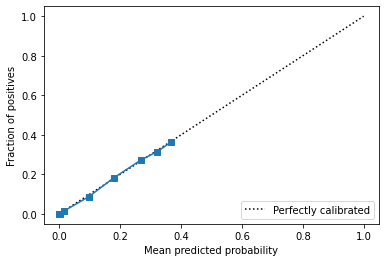

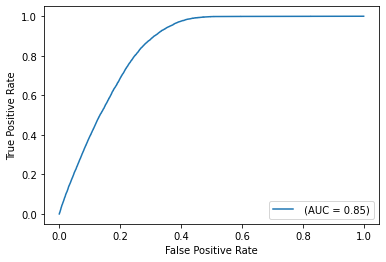

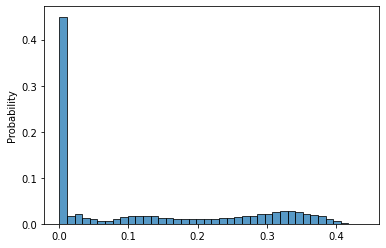

{'accuracy': 0.7618098011947557,
 'sensitivity': 0.7870985995190267,
 'precision': 0.3147860032248027,
 'fscore': 0.4497160985269454,
 'specificity': 0.7582414292130346,
 'negative_precision': 0.9618900508976729}

In [206]:
eval_clf(model_nn, X_test, y_test, threshold=0.22)

In [167]:
X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=None)
model = xgb.XGBClassifier(n_estimators=120, max_depth=2, learning_rate=0.2, subsample=0.9, colsample_bynode=0.6).fit(X_train,y_train)

accuracy: 0.7650722013766804
sensitivity: 0.776347432451549
precision: 0.3165484224490973
fscore: 0.4497254773416373
specificity: 0.7634812116373072
negative_precision: 0.9603058034873649


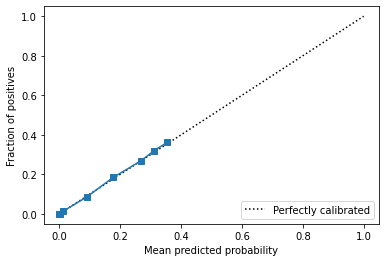

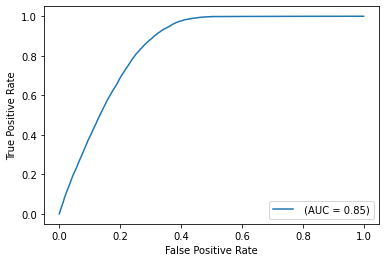

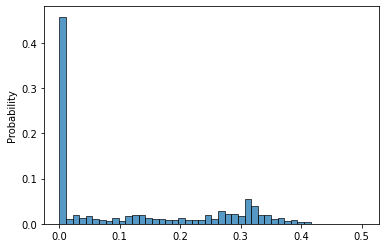

{'accuracy': 0.7650722013766804,
 'sensitivity': 0.776347432451549,
 'precision': 0.3165484224490973,
 'fscore': 0.4497254773416373,
 'specificity': 0.7634812116373072,
 'negative_precision': 0.9603058034873649}

In [181]:
eval_clf(model, X_test, y_test, threshold=0.23)

In [182]:
X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=0.6)
model_06 = xgb.XGBClassifier(n_estimators=120, max_depth=2, learning_rate=0.2, subsample=0.9, colsample_bynode=0.6).fit(X_train,y_train)

accuracy: 0.7620546998679296
sensitivity: 0.778257179233272
precision: 0.31371710432526445
fscore: 0.4471764442909106
specificity: 0.7597684515195369
negative_precision: 0.960446631339894


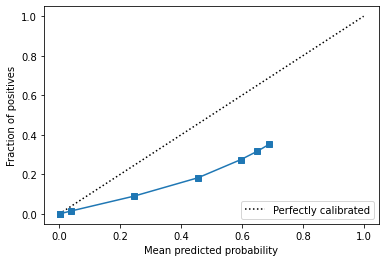

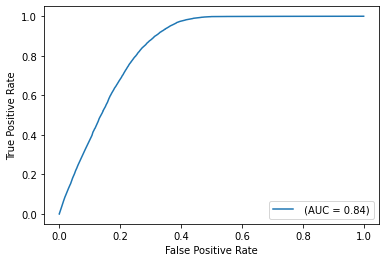

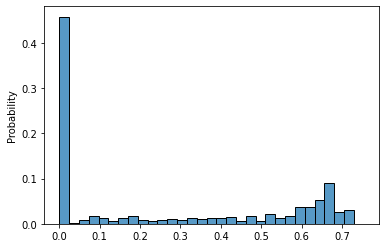

{'accuracy': 0.7620546998679296,
 'sensitivity': 0.778257179233272,
 'precision': 0.31371710432526445,
 'fscore': 0.4471764442909106,
 'specificity': 0.7597684515195369,
 'negative_precision': 0.960446631339894}

In [198]:
eval_clf(model_06, X_test, y_test, threshold=0.53)

Current Ratio:  None
accuracy: 0.8763524091906973
sensitivity: 7.073136228603763e-05
precision: 1.0
fscore: 0.00014145271942853102
specificity: 1.0
negative_precision: 0.8763513277122765


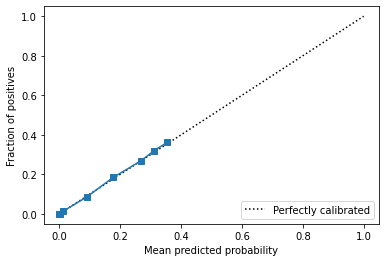

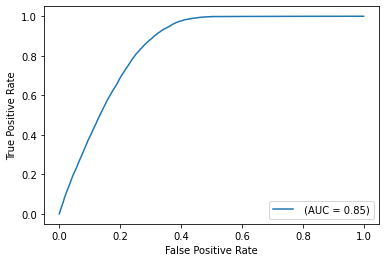

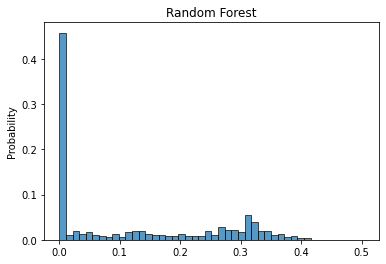

Current Ratio:  0.2
accuracy: 0.8763524091906973
sensitivity: 0.00028292544914415053
precision: 0.5714285714285714
fscore: 0.0005655708731000354
specificity: 0.999970058386147
negative_precision: 0.8763710791945839


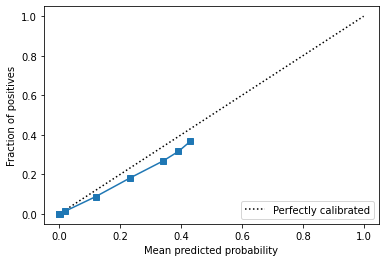

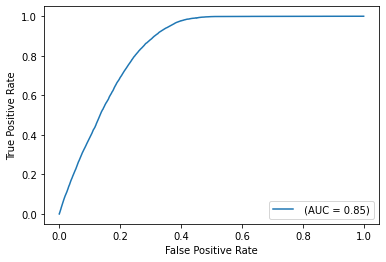

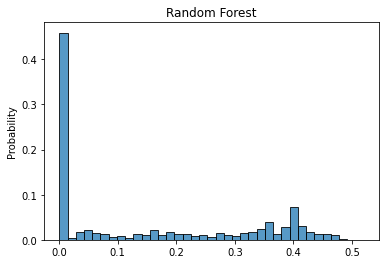

Current Ratio:  0.4
accuracy: 0.7837107396814568
sensitivity: 0.6960673362568963
precision: 0.3250751494731279
fscore: 0.44317849181509084
specificity: 0.7960776485852588
negative_precision: 0.9488817511301452


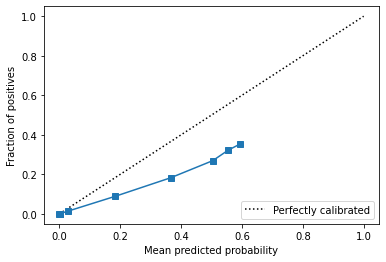

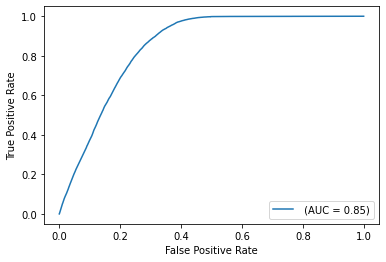

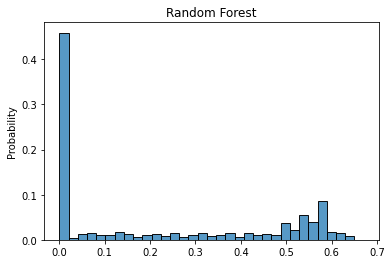

Current Ratio:  0.6
accuracy: 0.7483316277890023
sensitivity: 0.8203423397934644
precision: 0.3065658701628251
fscore: 0.44633442370598425
specificity: 0.7381705673935826
negative_precision: 0.9667978196363446


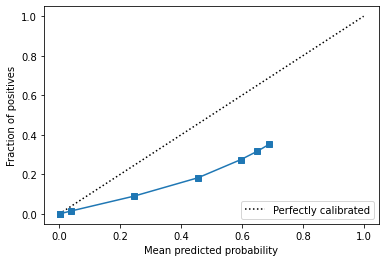

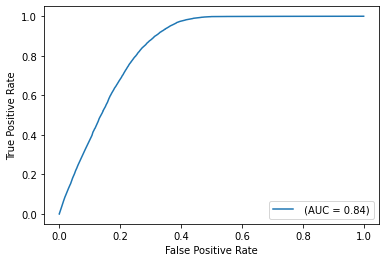

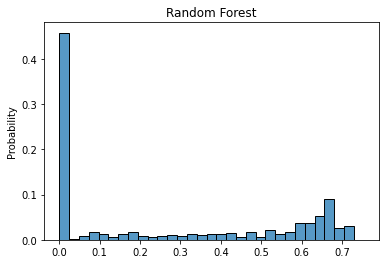

Current Ratio:  0.8
accuracy: 0.7248038624019312
sensitivity: 0.8766445041731504
precision: 0.2942964334900508
fscore: 0.4406598876484392
specificity: 0.7033784120964119
negative_precision: 0.9758512302856589


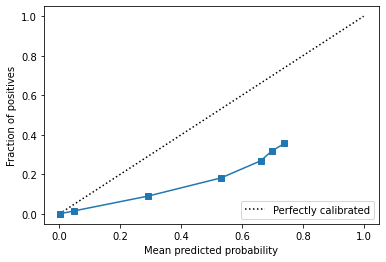

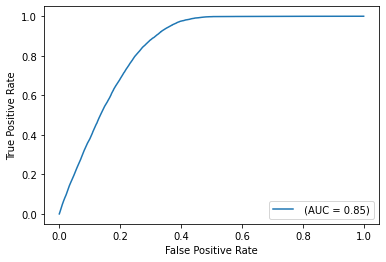

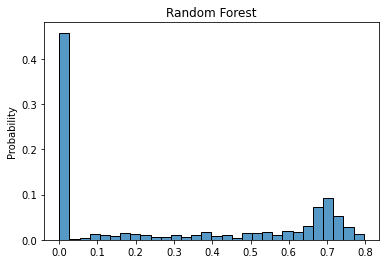

Current Ratio:  1.0
accuracy: 0.7072586217452529
sensitivity: 0.9043004668269911
precision: 0.28473119237450445
fscore: 0.4330962059620596
specificity: 0.6794550626278757
negative_precision: 0.9805130273220896


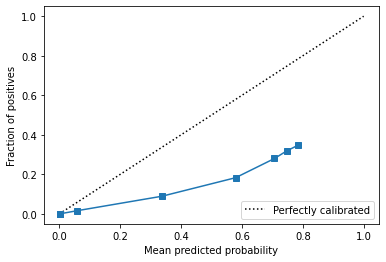

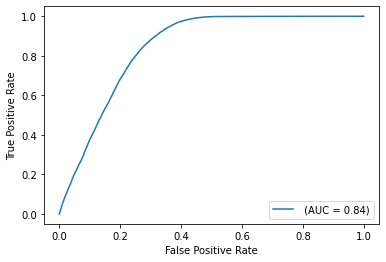

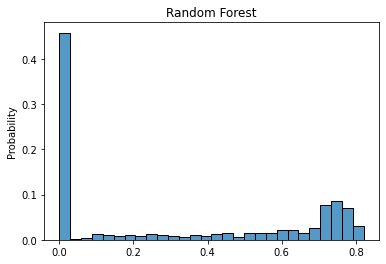

In [165]:
ratios = [None,0.2,0.4,0.6,0.8,1.0]
metrics = []
for ratio in ratios:
    print('Current Ratio: ', ratio)
    X_train, X_test, y_train, y_test = preprocessing(data, upsampling_ratio=ratio)
    model = xgb.XGBClassifier(n_estimators=120, max_depth=2, learning_rate=0.2, subsample=0.9, colsample_bynode=0.6).fit(X_train,y_train)
    metrics.append(eval_clf(model, X_test, y_test, clf_name='Random Forest'))

In [166]:
for metric in metrics:
    print(metric)

{'accuracy': 0.8763524091906973, 'sensitivity': 7.073136228603763e-05, 'precision': 1.0, 'fscore': 0.00014145271942853102, 'specificity': 1.0, 'negative_precision': 0.8763513277122765}
{'accuracy': 0.8763524091906973, 'sensitivity': 0.00028292544914415053, 'precision': 0.5714285714285714, 'fscore': 0.0005655708731000354, 'specificity': 0.999970058386147, 'negative_precision': 0.8763710791945839}
{'accuracy': 0.7837107396814568, 'sensitivity': 0.6960673362568963, 'precision': 0.3250751494731279, 'fscore': 0.44317849181509084, 'specificity': 0.7960776485852588, 'negative_precision': 0.9488817511301452}
{'accuracy': 0.7483316277890023, 'sensitivity': 0.8203423397934644, 'precision': 0.3065658701628251, 'fscore': 0.44633442370598425, 'specificity': 0.7381705673935826, 'negative_precision': 0.9667978196363446}
{'accuracy': 0.7248038624019312, 'sensitivity': 0.8766445041731504, 'precision': 0.2942964334900508, 'fscore': 0.4406598876484392, 'specificity': 0.7033784120964119, 'negative_precisi

<h2>Calibration of the Models</h2>

- It turns out that our models are already quite well calibrated and further calibration is not needed

In [125]:
X_calib, X_val, y_calib, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=45)

accuracy: 0.7647244039393356
sensitivity: 0.7774768353528154
precision: 0.3144784639335755
fscore: 0.4478200180638805
specificity: 0.762940660392407
negative_precision: 0.9608025311370028


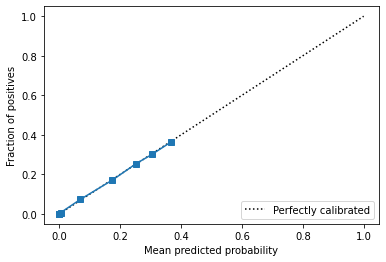

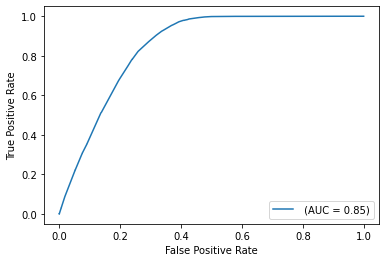

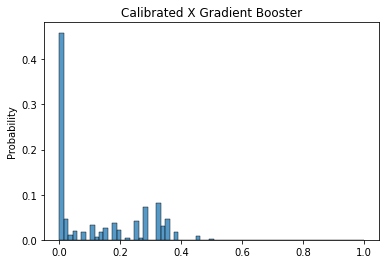

{'accuracy': 0.7647244039393356,
 'sensitivity': 0.7774768353528154,
 'precision': 0.3144784639335755,
 'fscore': 0.4478200180638805,
 'specificity': 0.762940660392407,
 'negative_precision': 0.9608025311370028}

In [133]:
nn_calib = CalibratedClassifierCV(base_estimator=nn, method='isotonic', cv='prefit').fit(X_calib,y_calib)
eval_clf(nn_calib, X_val, y_val, clf_name='Calibrated X Gradient Booster', threshold=0.24)

accuracy: 0.8643098290972064
sensitivity: 0.14697077690662866
precision: 0.36768901569186874
fscore: 0.21000101843364904
specificity: 0.9646474716860743
negative_precision: 0.8899251329028935


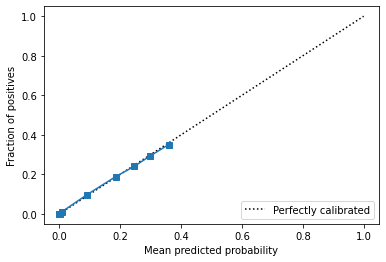

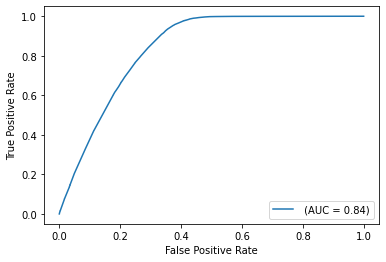

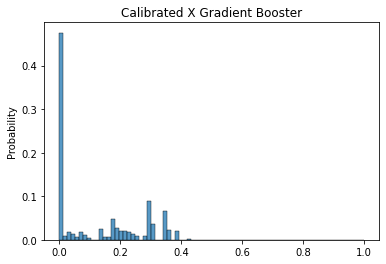

{'accuracy': 0.8643098290972064,
 'sensitivity': 0.14697077690662866,
 'precision': 0.36768901569186874,
 'fscore': 0.21000101843364904,
 'specificity': 0.9646474716860743,
 'negative_precision': 0.8899251329028935}

In [264]:
xgb_calib = CalibratedClassifierCV(base_estimator=xgbclf, method='isotonic', cv='prefit').fit(X_calib,y_calib)
eval_clf(xgb_calib, X_val, y_val, clf_name='Calibrated X Gradient Booster', threshold=0.35)

In [ ]:
gb_calib = CalibratedClassifierCV(base_estimator=gb, method='isotonic', cv='prefit').fit(X_calib,y_calib)
eval_clf(gb_calib, X_val, y_val, clf_name='Calibrated Gradient Booster')

In [ ]:
rf_calib = CalibratedClassifierCV(base_estimator=rf, method='sigmoid', cv='prefit').fit(X_calib,y_calib)
eval_clf(rf_calib, X_val, y_val, clf_name='Calibrated Random Forest')

In [ ]:
lrc = LogisticRegression()
lr_calib = CalibratedClassifierCV(base_estimator=lrc, method='sigmoid').fit(X_train,y_train)
eval_clf(lr_calib, X_test, y_test, clf_name='Calibrated Logistic Regression')